In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d omkargurav/face-mask-dataset

100% 163M/163M [00:07<00:00, 27.5MB/s]
100% 163M/163M [00:07<00:00, 23.5MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-mask-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

In [ ]:
with_mask='/content/data/with_mask'
without_mask='/content/data/without_mask'
pd.DataFrame([len(os.listdir(with_mask)),len(os.listdir(without_mask))],columns=['Number'],index=['with_mask','without_mask'])

Number
with_mask       3725
without_mask    3828

In [ ]:
def size_path(path):
    size=[]
    for img in os.listdir(path):
            img_array=cv2.imread(os.path.join(path,img))
            size.append(img_array.shape)
    return pd.DataFrame(pd.Series(size).value_counts(),columns=['Number'])

In [ ]:
#with_mask
size_path(with_mask)

Number
(225, 225, 3)       434
(428, 320, 3)       162
(100, 100, 3)       149
(275, 183, 3)        86
(183, 275, 3)        85
...                 ...
(2000, 2000, 3)       1
(156, 103, 3)         1
(129, 86, 3)          1
(185, 111, 3)         1
(439, 780, 3)         1

[1726 rows x 1 columns]

In [ ]:
#without_mask
size_path(without_mask)

Number
(225, 225, 3)     230
(428, 320, 3)     219
(275, 183, 3)     169
(183, 275, 3)      96
(259, 194, 3)      85
...               ...
(292, 173, 3)       1
(88, 99, 3)         1
(120, 150, 3)       1
(135, 157, 3)       1
(131, 133, 3)       1

[1263 rows x 1 columns]

In [ ]:
Size=150
code={'with_mask':0,'without_mask':1}
def get_Name(N):
    for x,y in code.items():
          if y==N:
                return x

In [ ]:
def load(path):
    label=[]
    data=[]
    temp=path.split('/')[-1]
    for img in os.listdir(path):
            img_array=cv2.imread(os.path.join(path,img))
            img_array=cv2.resize(img_array,(Size,Size))
            label.append(code[temp])
            data.append(img_array)
    return label,data

In [ ]:
#with_mask
label_with,data_with=load(with_mask)
#without_mask
label_without,data_without=load(without_mask)

In [ ]:
data=data_with+data_without
label=label_with+label_without
label=pd.DataFrame(label,columns=['Label'])
label

Label
0         0
1         0
2         0
3         0
4         0
...     ...
7548      1
7549      1
7550      1
7551      1
7552      1

[7553 rows x 1 columns]

In [ ]:
pd.DataFrame(label).value_counts()

Label
1        3828
0        3725
dtype: int64

<ipython-input-32-dca88cb00b19>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(label['Label'],shade = False , color = "red")


Text(0.5, 0, 'Labels')

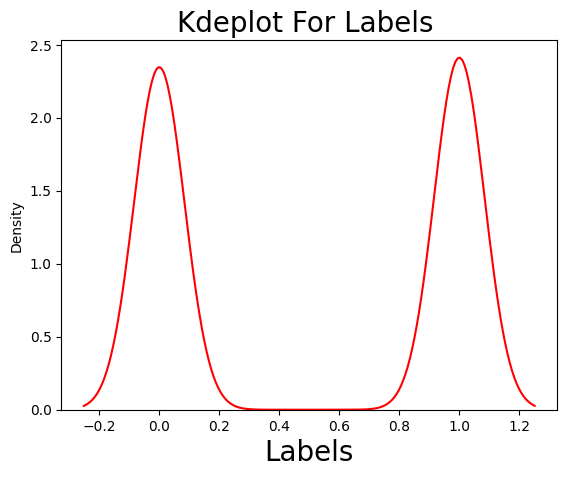

In [ ]:
sns.kdeplot(label['Label'],shade = False , color = "red")
plt.title('Kdeplot For Labels ',fontsize=20)
plt.xlabel('Labels',fontsize=20)

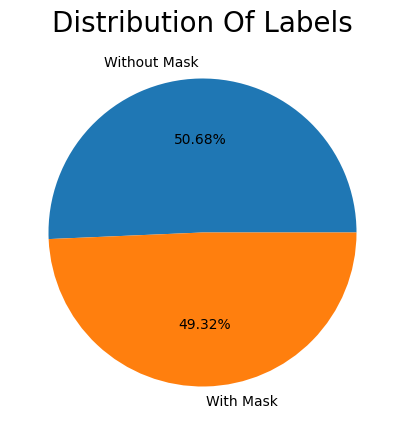

In [ ]:
plt.figure(figsize=(5,5))
plt.pie(label['Label'].value_counts(),labels=['Without Mask','With Mask'],autopct ='%1.2f%%')
plt.title('Distribution Of Labels',fontsize=20)
plt.show()

In [ ]:
def show(data,y):
    plt.figure(figsize=(25,25))
    i=1
    for x in np.random.randint(0,len(data),50):
        plt.subplot(10,5,i)
        plt.imshow(data[x])
        plt.title(f'Label {get_Name(y[x])}',fontsize=15)
        plt.axis('off')
        i+=1

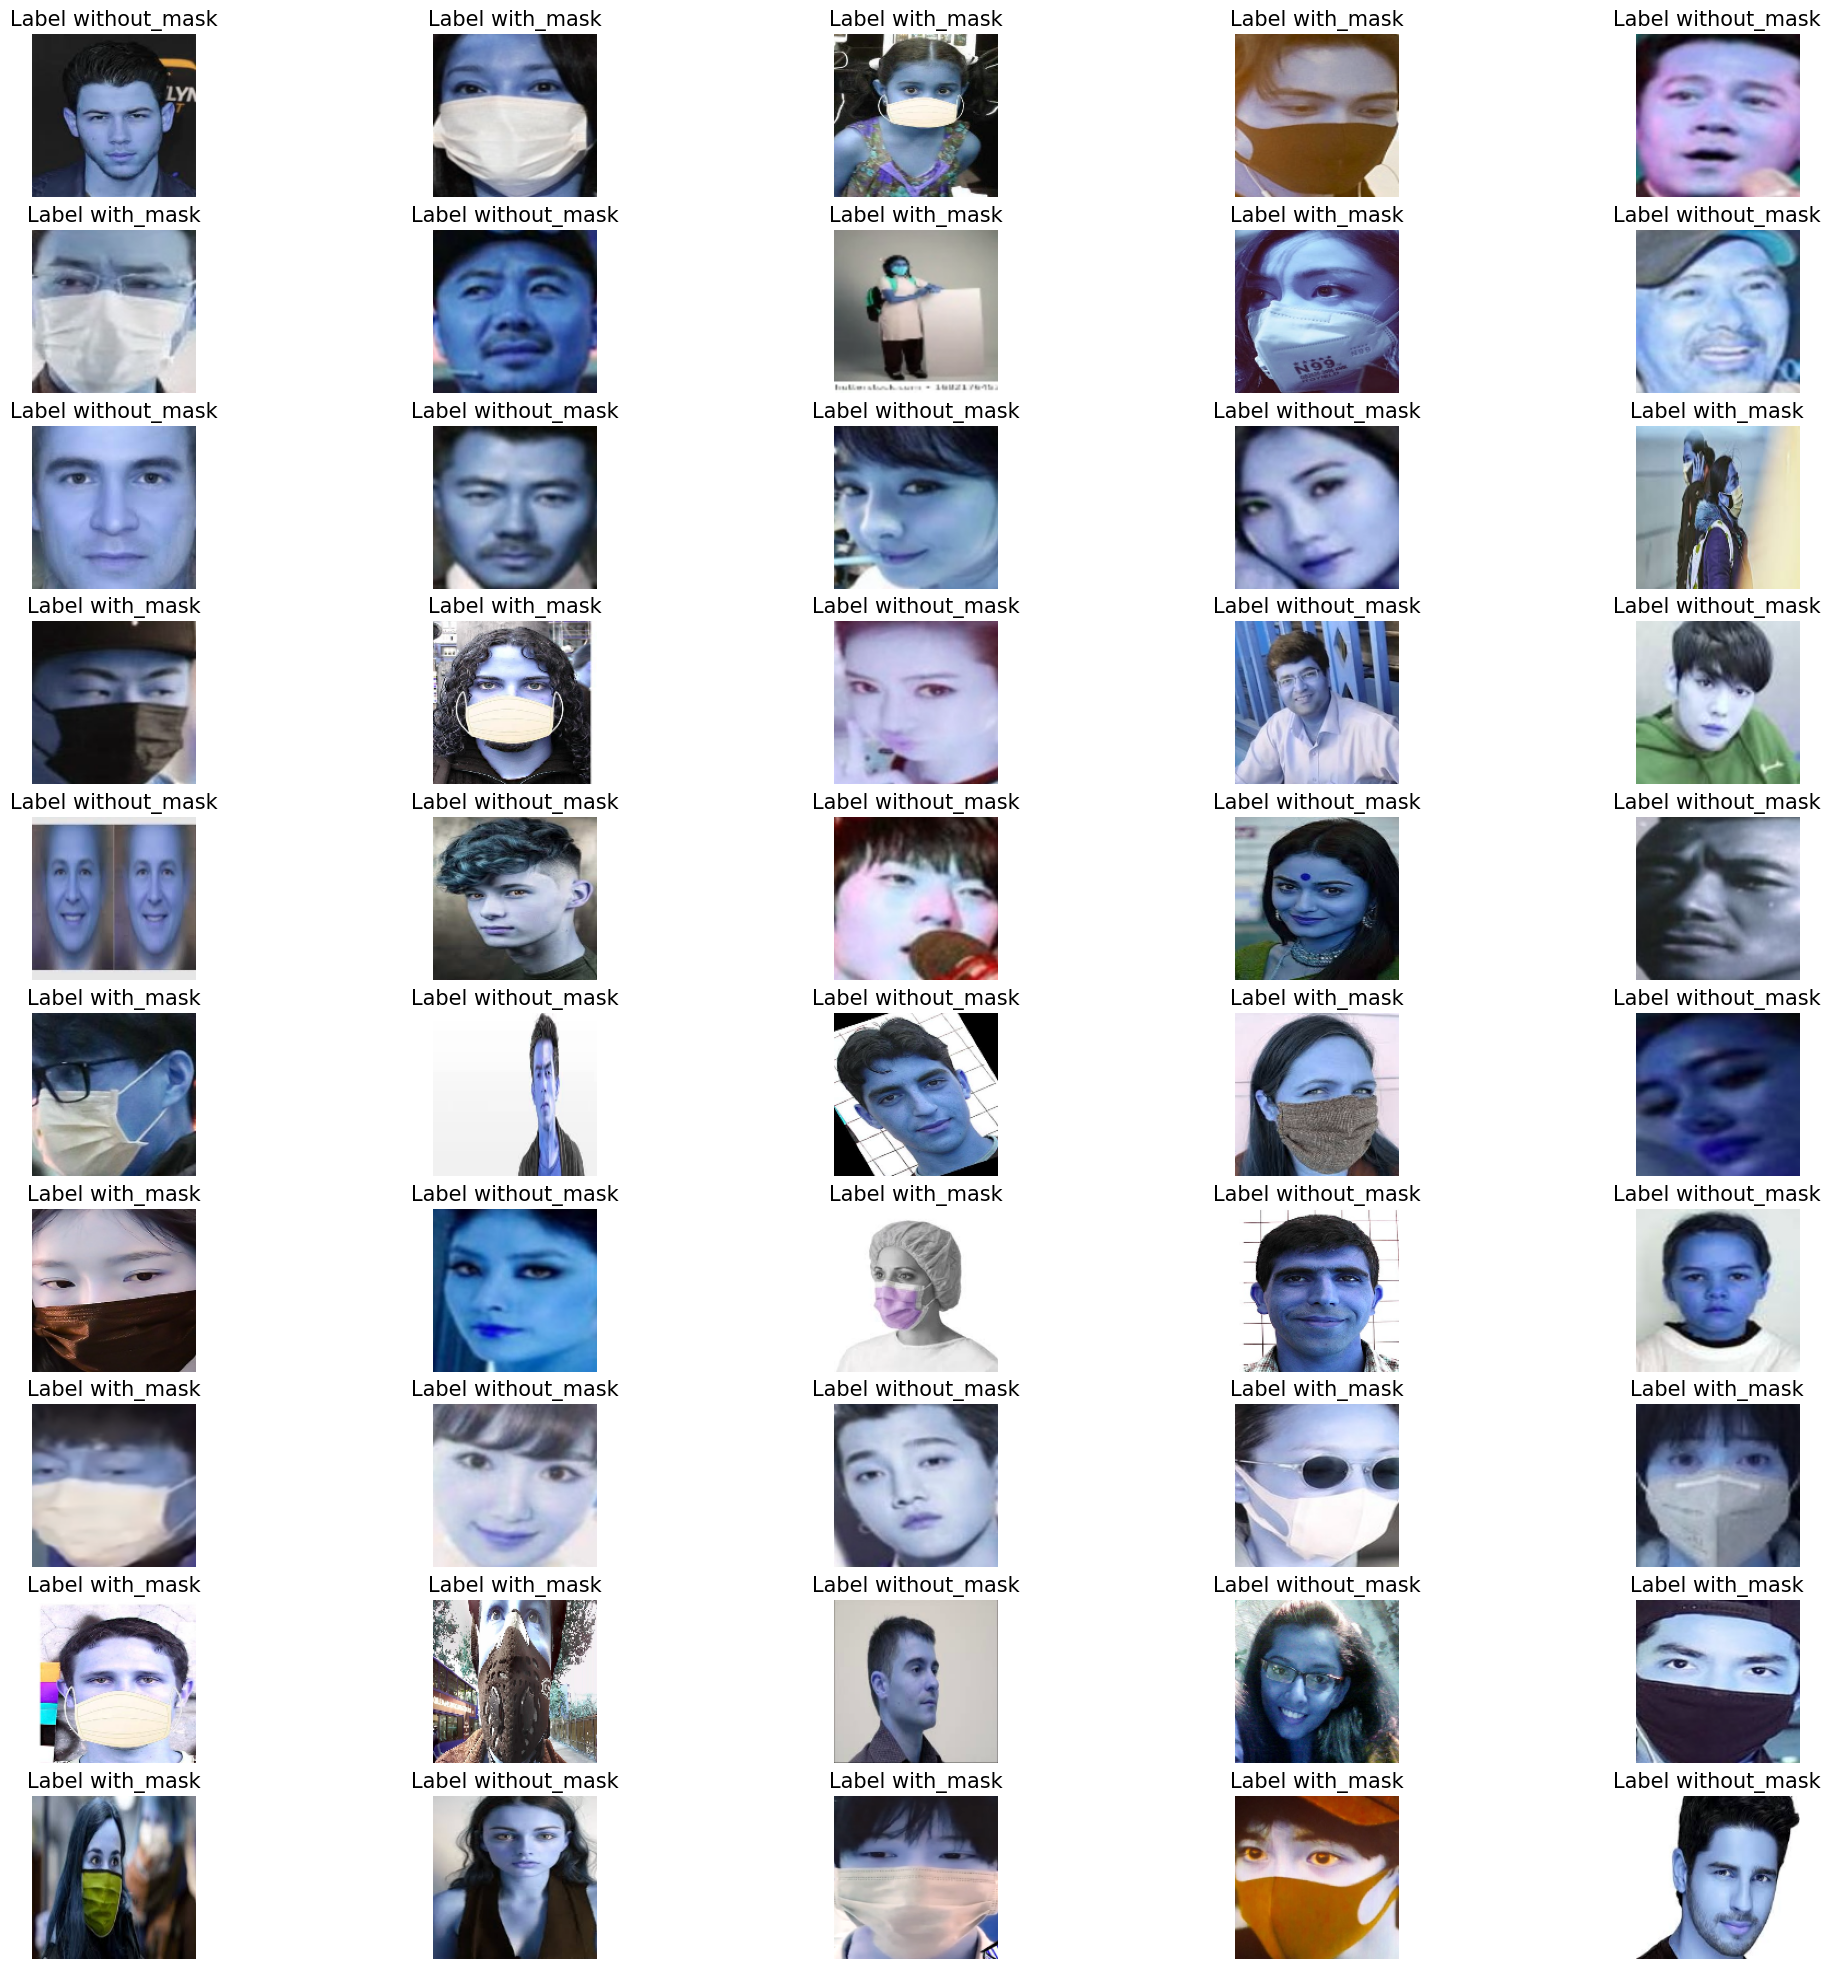

In [ ]:
#show
show(data,label['Label'])

In [ ]:
data=np.array(data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data,label, test_size=0.15,random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (6420, 150, 150, 3)
X_test shape is  (1133, 150, 150, 3)
y_train shape is  (6420, 1)
y_test shape is  (1133, 1)


In [ ]:
class_num=2
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(Size,Size,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3,3)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3,3)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3,3)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(class_num,activation=tf.nn.softmax))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 47, 47, 64)       2

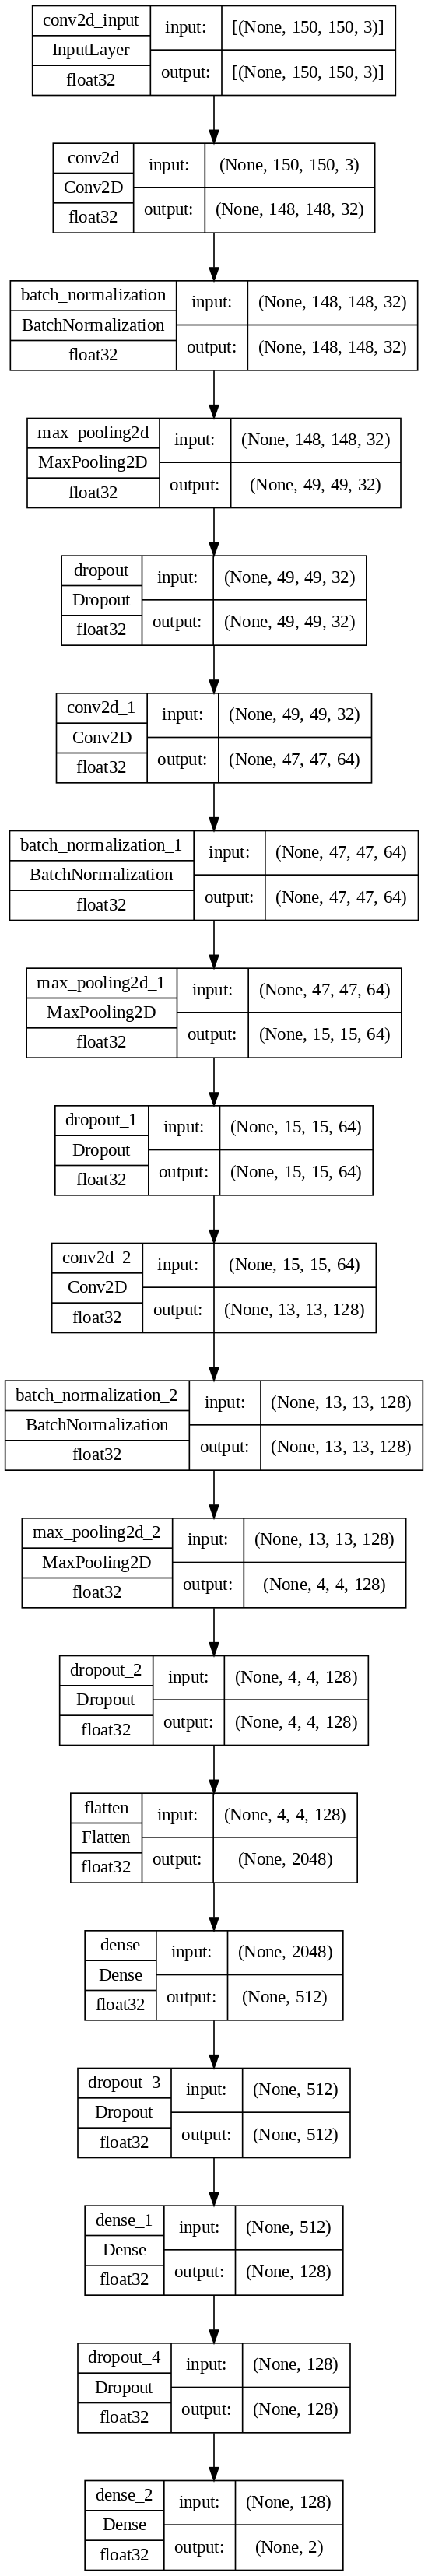

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
model.compile(optimizer ='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=model.fit(X_train,y_train,epochs=2,validation_split = 0.1)

Epoch 1/2
181/181 [==============================] - 18s 34ms/step - loss: 0.6363 - accuracy: 0.8075 - val_loss: 0.3469 - val_accuracy: 0.8551
Epoch 2/2
181/181 [==============================] - 5s 29ms/step - loss: 0.2904 - accuracy: 0.8795 - val_loss: 0.3565 - val_accuracy: 0.8489


In [ ]:
score, acc = model.evaluate(X_test, y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

36/36 [==============================] - 0s 12ms/step - loss: 0.3083 - accuracy: 0.8853
Test Loss = 0.3083009421825409
Test Accuracy = 0.8852603435516357


In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  0.636282  0.807546  0.346929       0.85514
1  0.290407  0.879543  0.356538       0.84891

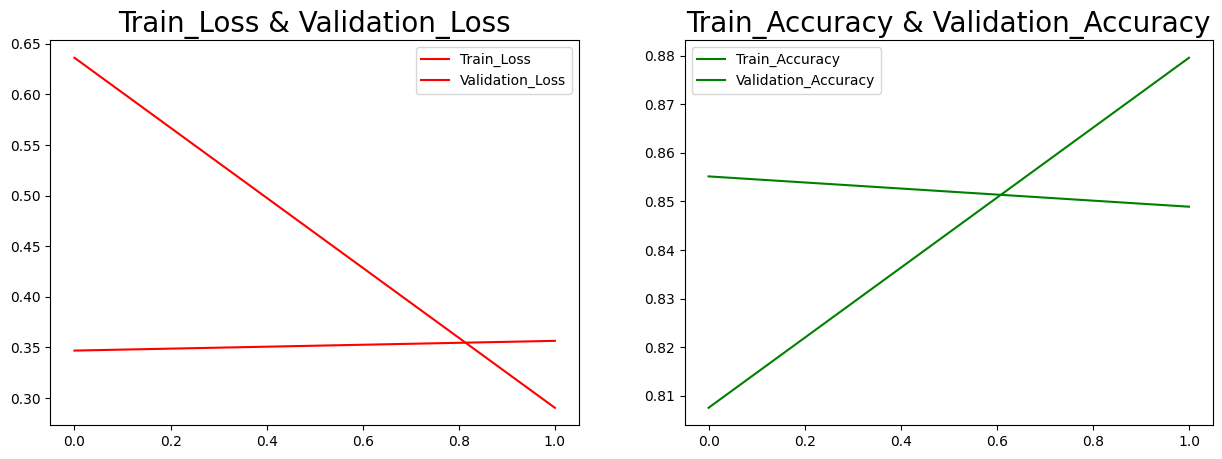

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],c='r',label='Train_Loss')
plt.plot(hist_['val_loss'],c='r',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],c='green',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],c='green',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
prediction = model.predict(X_test)
prediction[0]

36/36 [==============================] - 0s 6ms/step


array([6.3183634e-06, 9.9999368e-01], dtype=float32)

In [ ]:
pred_name=[]
pred=[]
for row in prediction:
    N=np.argmax(row)
    pred_name.append(get_Name(N))
    pred.append(N)
df=pd.DataFrame()
df['actual_label'],df['predict_label'],df['predict_name']=y_test,pred,pred_name
df

actual_label  predict_label  predict_name
6790             1              1  without_mask
3984             1              1  without_mask
1420             0              0     with_mask
3850             1              1  without_mask
1492             0              1  without_mask
...            ...            ...           ...
4332             1              1  without_mask
3713             0              0     with_mask
2250             0              1  without_mask
5956             1              1  without_mask
1633             0              0     with_mask

[1133 rows x 3 columns]

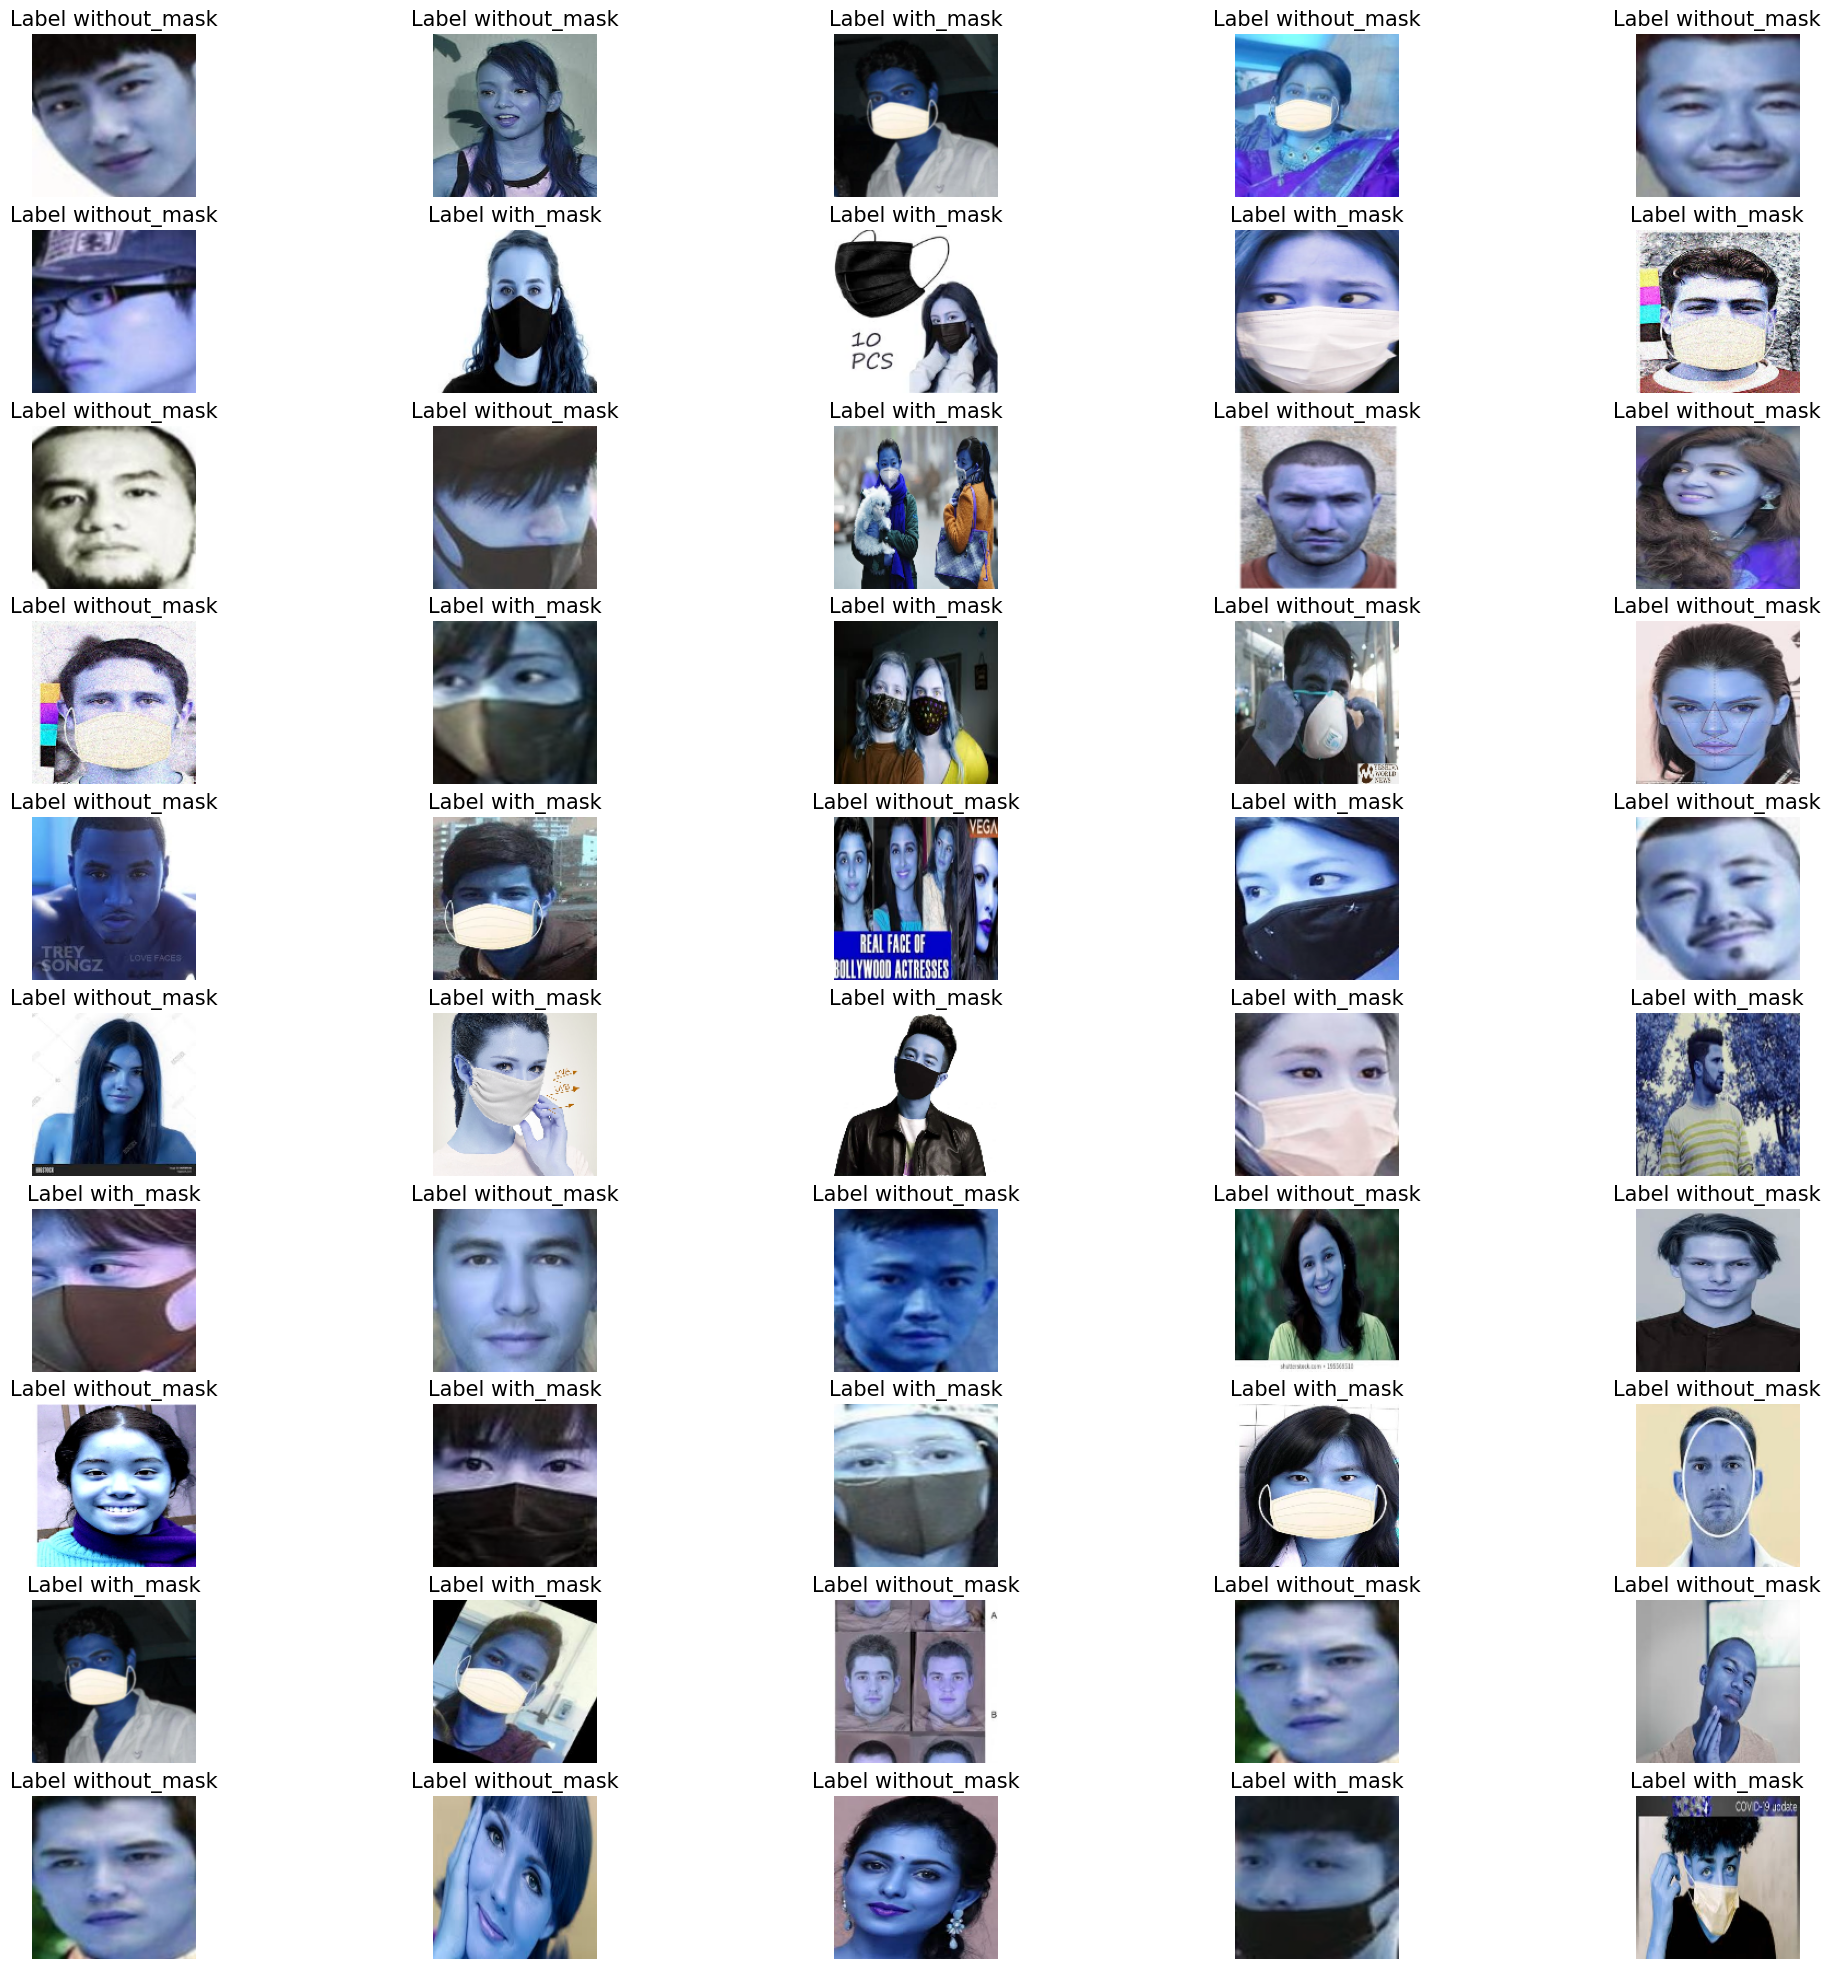

In [ ]:
show(X_test,pred)

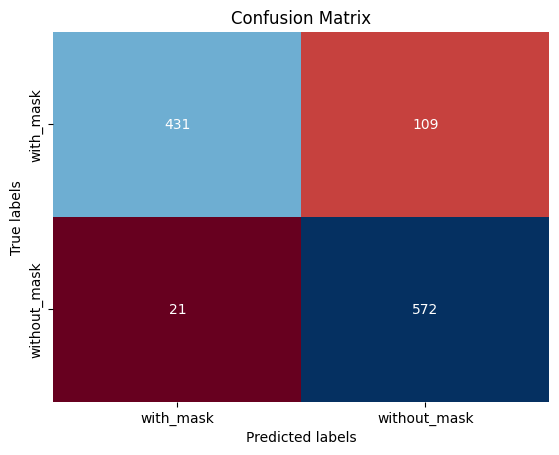

array([[431, 109],
       [ 21, 572]])

In [ ]:
ax= plt.subplot()
CM = confusion_matrix(y_test,pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(code.keys())
ax.yaxis.set_ticklabels(code.keys())
plt.show()
CM

In [ ]:
model.save('/kaggle/working/model.h5')